               Element  Interfacial Excess (nm-2)  Error (nm-2)
0   B cumulative (cts)                       0.56          0.02
1  Ni cumulative (cts)                      -1.21          0.08
2  Mo cumulative (cts)                       2.61          0.13
3  Co cumulative (cts)                      -0.98          0.05
4  Cr cumulative (cts)                      -1.73          0.07
5  Al cumulative (cts)                       0.14          0.02
6  Ti cumulative (cts)                       0.56          0.05
7   C cumulative (cts)                       1.24          0.13


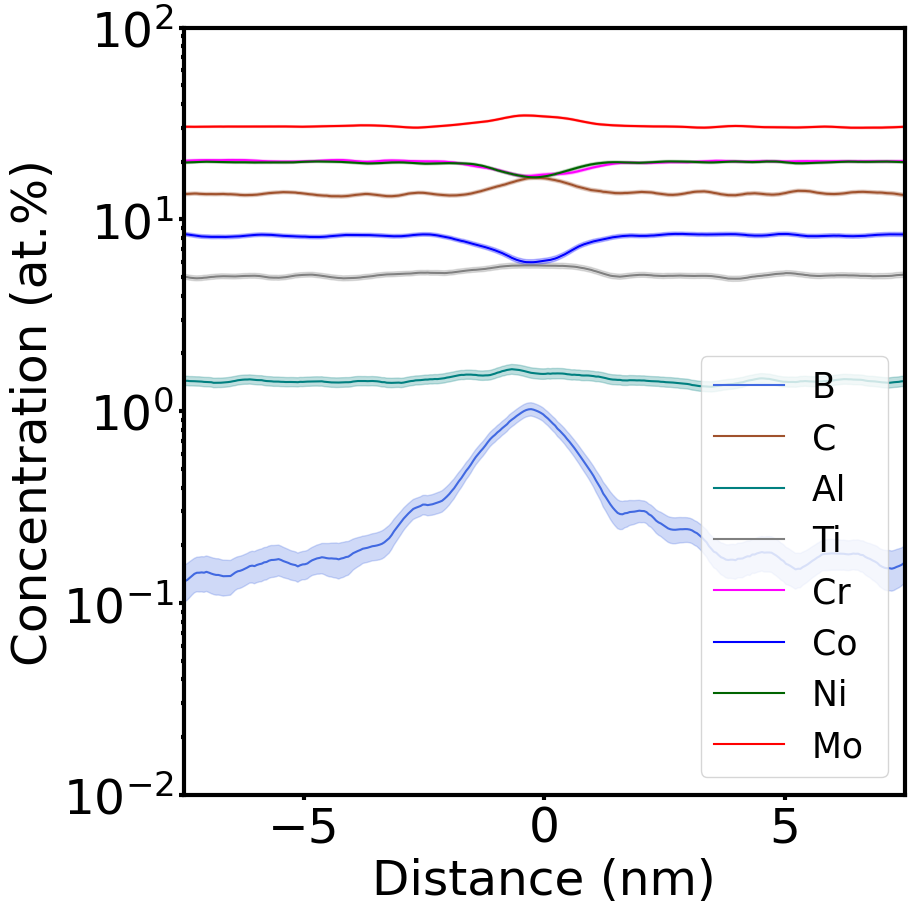

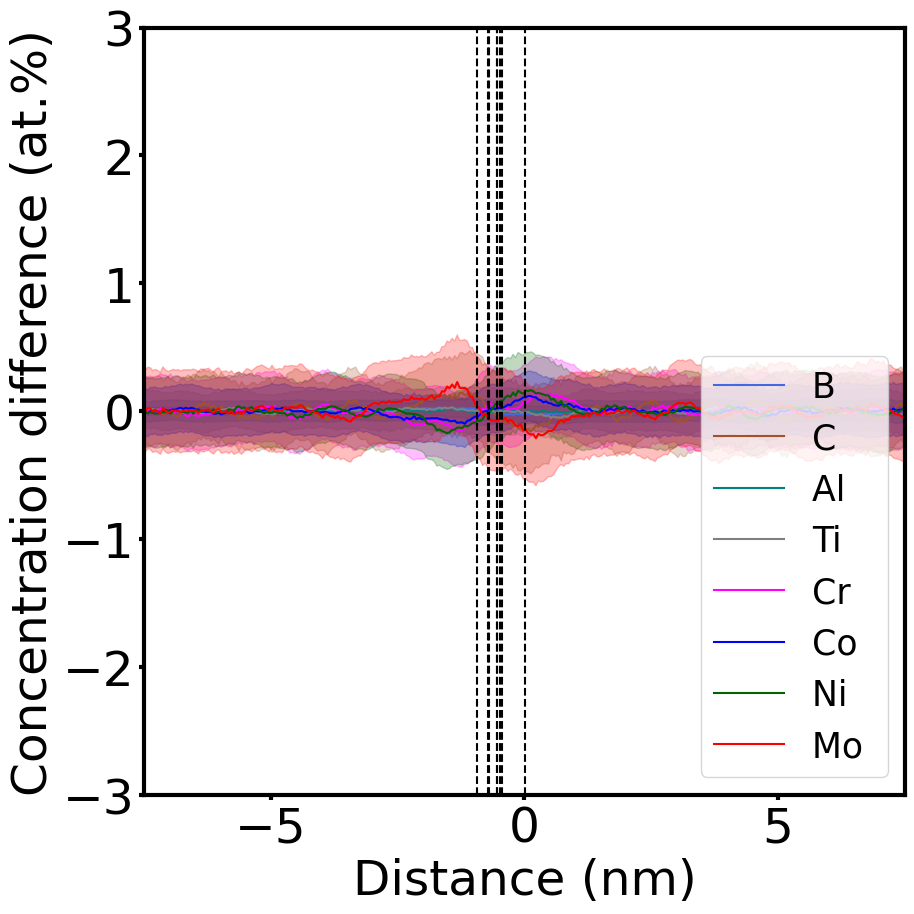

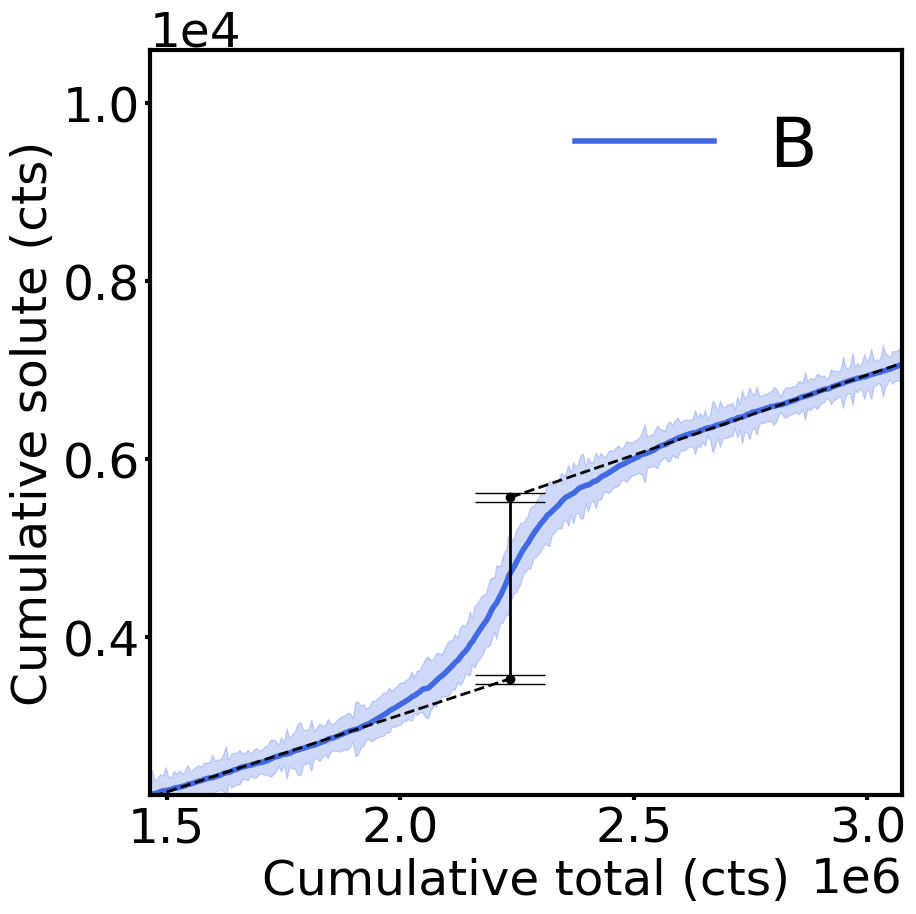

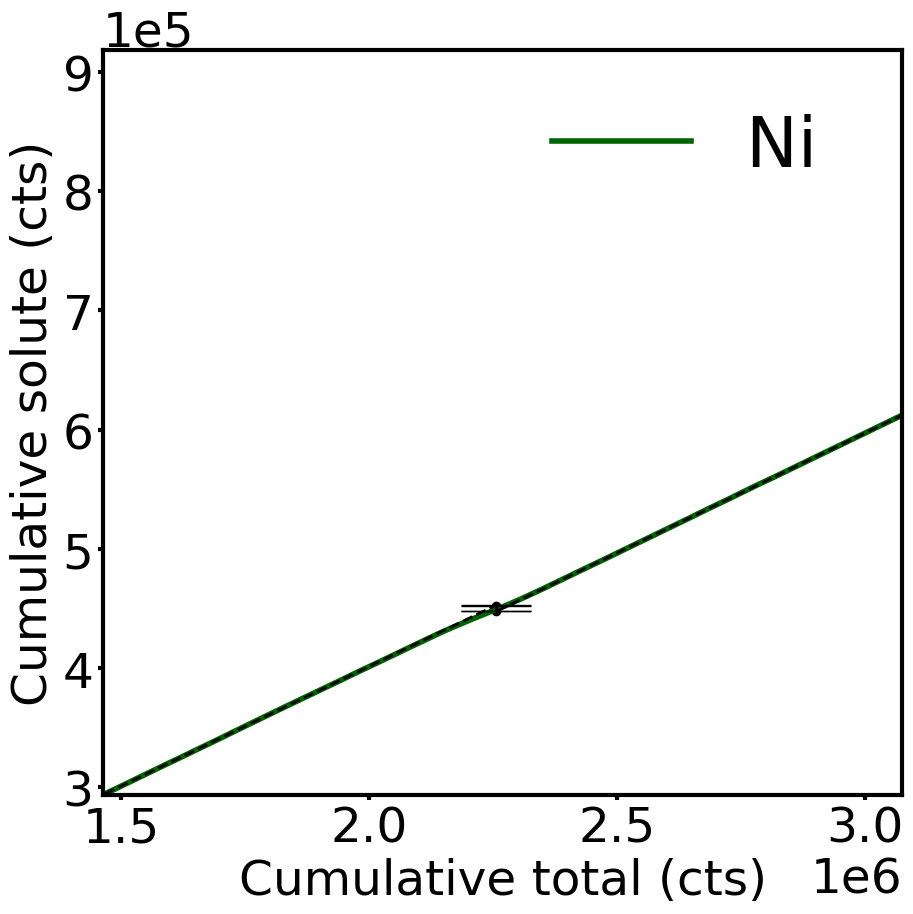

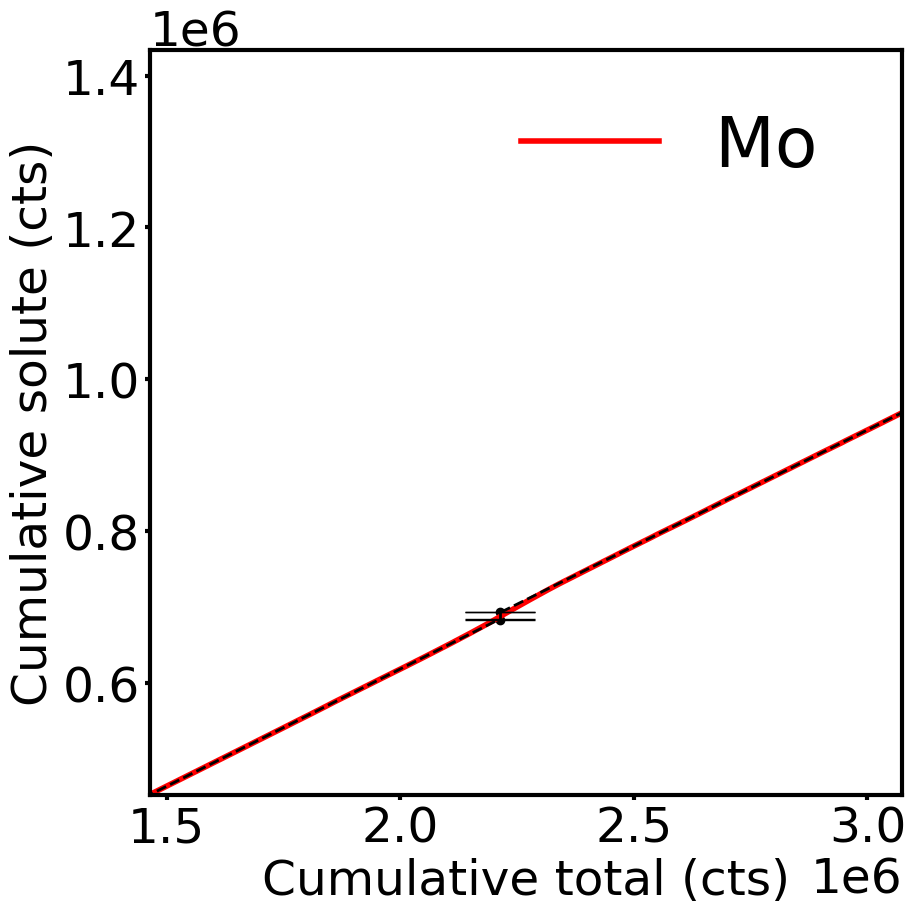

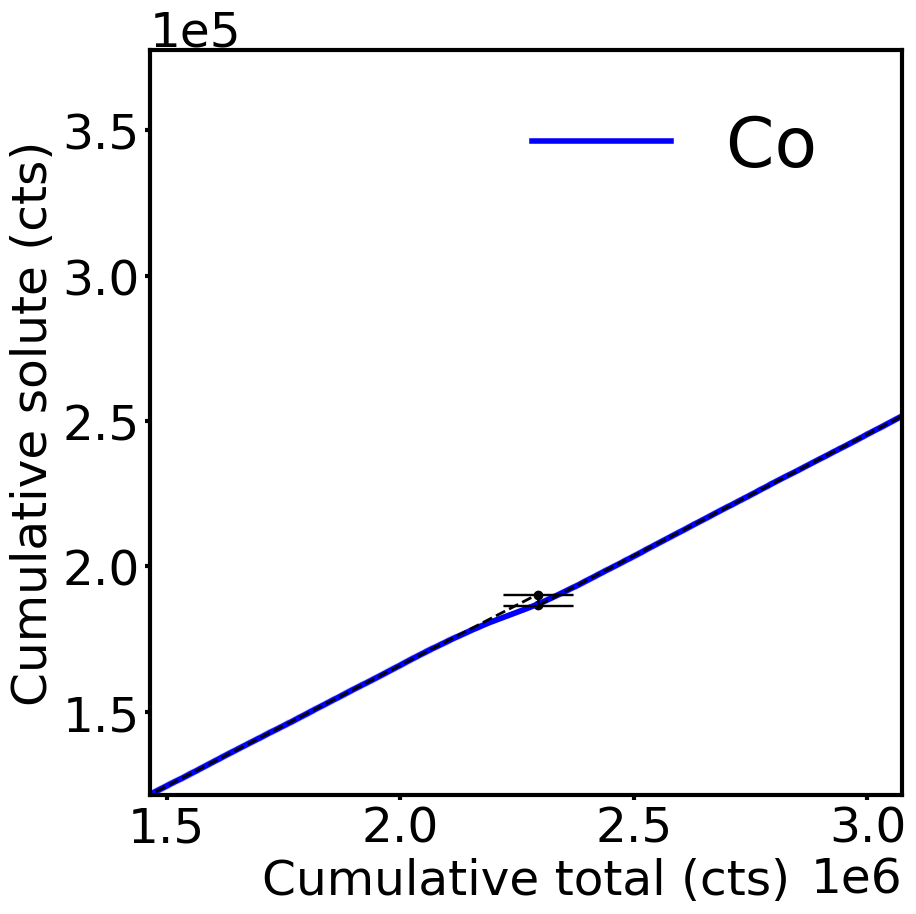

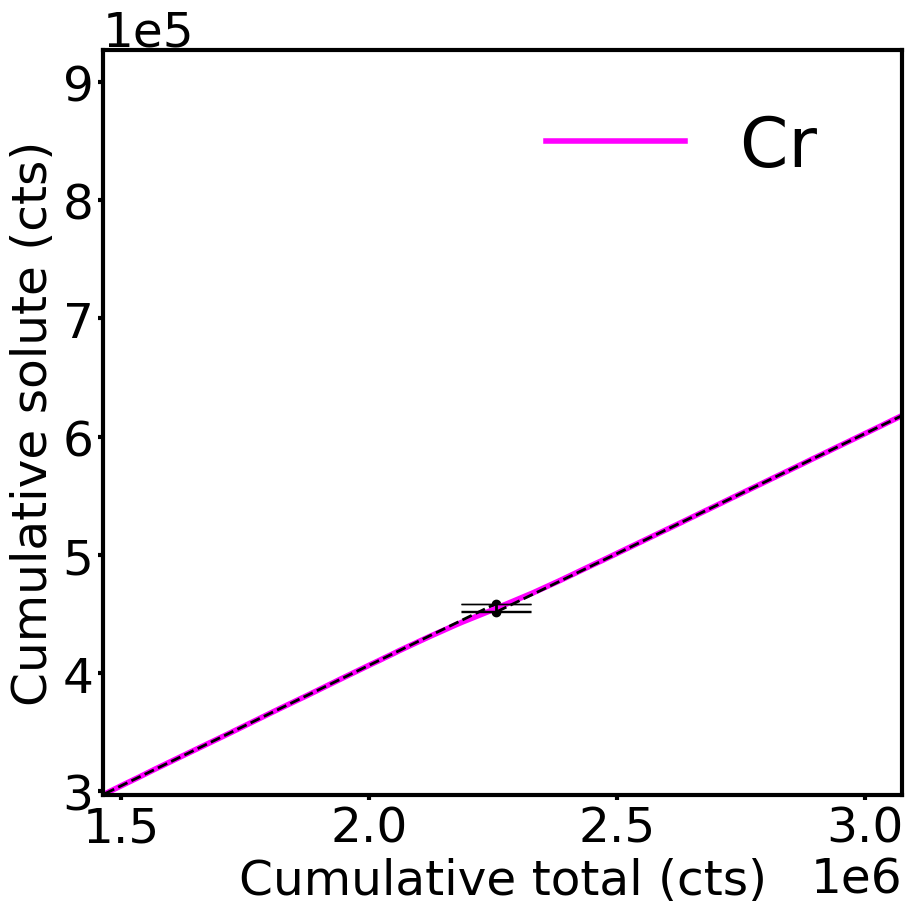

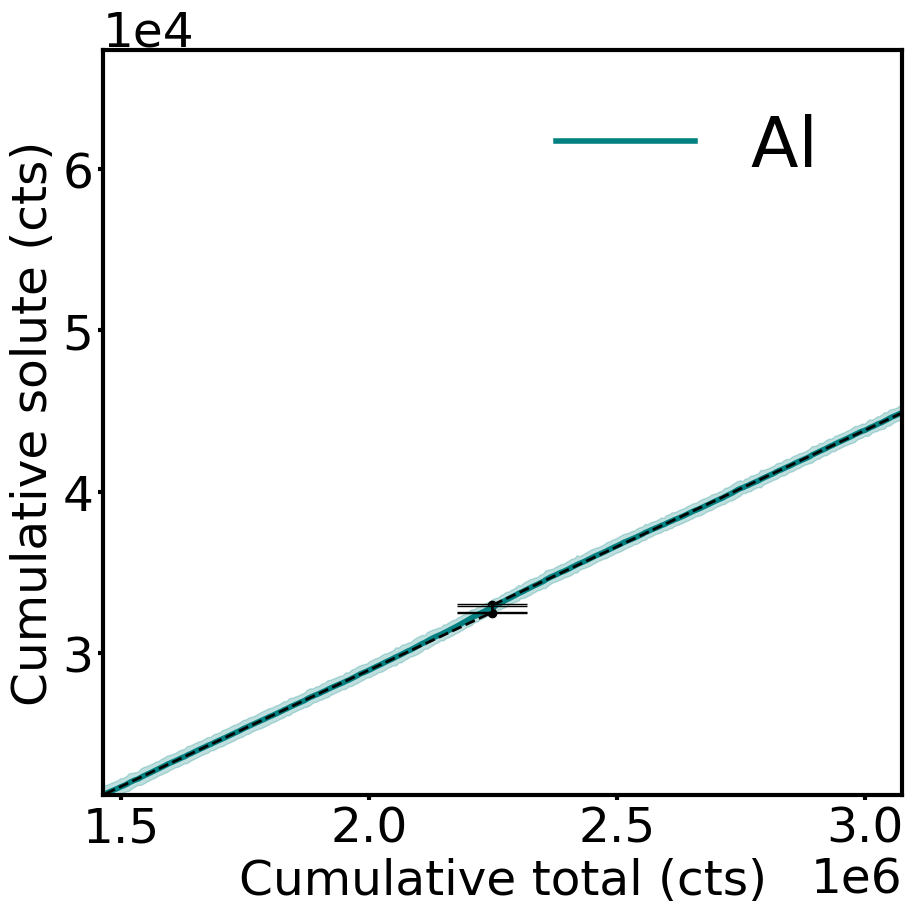

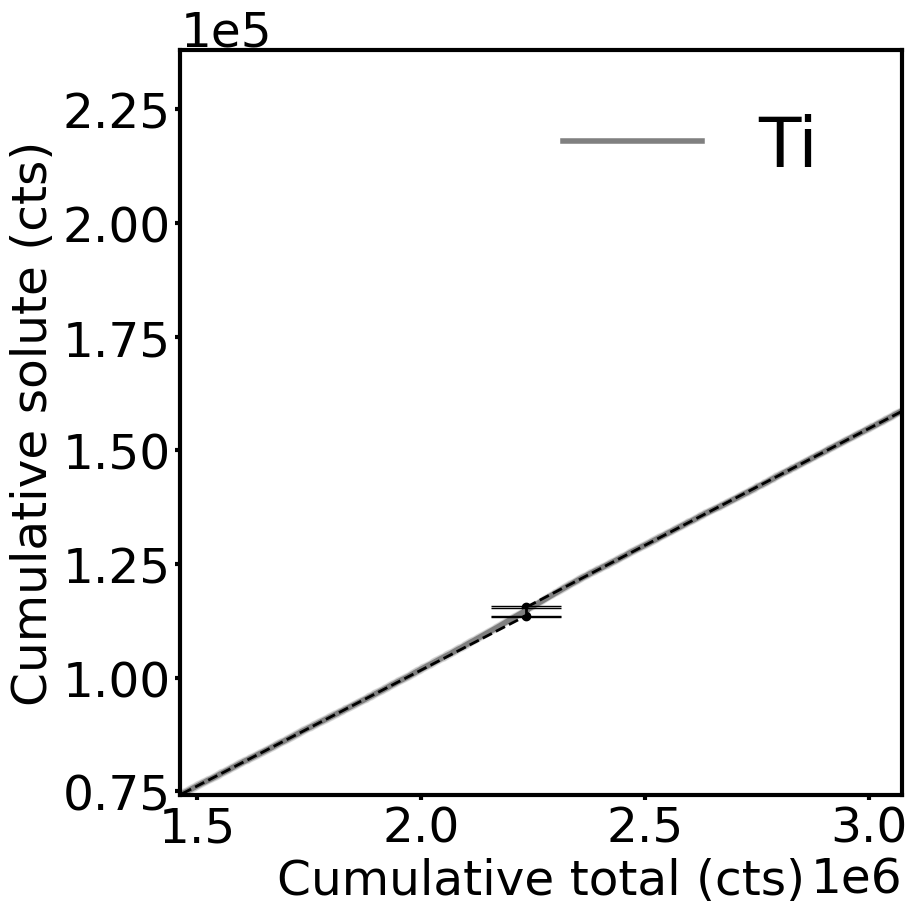

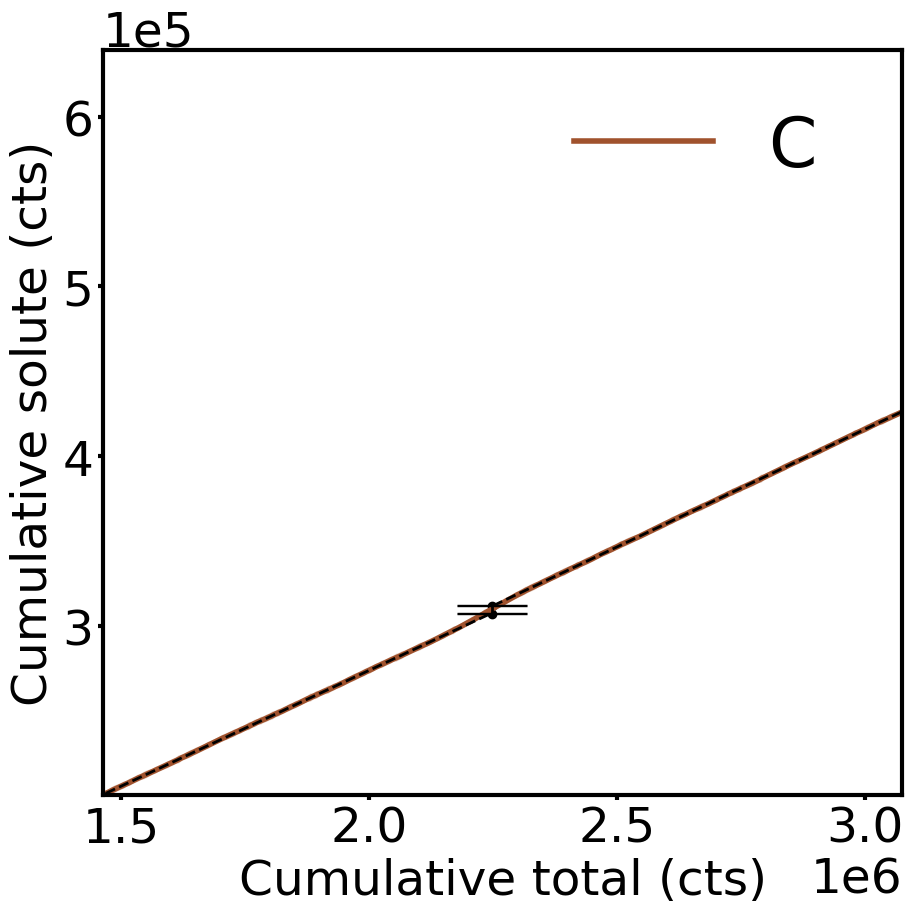

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 12 20:16:23 2022
@author: felixtheska
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob


## Defining input documents and elements of interest
Proxygram = '../test/Proxi-M6C_M6C-2091-R18_61180.csv'
ElementList = ["B", "C", "Al", "Ti", "Cr", "Co", "Ni", "Mo"]
ErrorList = ElementList
ElementList = [x + " atom% Corrected" for x in ElementList]
ErrorList = [x + " atom% Sigma" for x in ErrorList]
ColorList = ['royalblue', 'sienna', 'teal', 'grey', 'magenta', 'blue', 'darkgreen', 'red']
ProxyName = Proxygram.replace('-Proxigram.csv', '')

## Defining globally used variables for calculation & presentation
# Measured area in nm2 (e.g. obtained from IVAS)
Area = 3667.7

# Smoothing step size, e.g. 20 steps for 0.05 nm proxygram steps limit resolution to ~ 1 nm
Step = 0.05
AvgSteps = 20 #20
StDev = 5 #5
LimitLow = -7.5
LimitUp = 7.5
# Font size and lines to get graphs publication ready
plt.rc('font', size=35)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', width=3)
plt.rc('ytick.major', width=3)
plt.rc('ytick.minor', width=3)
LineWidth = 2
Format = ".svg"


## Defining the different functions
# Reading CSV file function
def Read_in(File_Name, Selection):
    Data = pd.read_csv(File_Name,header=1,usecols=Selection)
    return Data

# Generating concentration profiles
def Profile_concentration(Distance, Concentration):
    Concentration = Concentration.rolling(AvgSteps,win_type='gaussian').mean(std=StDev)
    Data = pd.concat([Distance, Concentration], axis=1)
    return Data

# Generating concentration errors
def Profile_error(Distance, Error):
    Error = Error.rolling(AvgSteps,win_type='gaussian').mean(std=StDev)
    Data = pd.concat([Distance, Error], axis=1)
    return Data

# Generating differential concentration profiles
def Profile_differential(Distance, Concentration, Error):
    Difference = Concentration.diff()
    Difference = Difference.rolling(AvgSteps,win_type='gaussian').mean(std=StDev)
    Data = pd.concat([Distance, Difference], axis=1).drop(0)    
    return Data

def Profile_diff_error(Distance, Error):
    Difference = Error.diff()
    Difference = Error.rolling(AvgSteps,win_type='gaussian').mean(std=StDev)
    Data = pd.concat([Distance, Difference], axis=1).drop(0)
    return Data

# Generating cumulative atom count profiles
def Profile_cumulative(Distance, Concentration, Error, AtomCount):
    Counts = Concentration.mul(AtomCount.values, axis=0)/100
    Cumulative = Counts.cumsum()
    Total = Counts.sum(axis=1, numeric_only=True).cumsum()
    Data = pd.concat([Distance, Total, Cumulative], axis=1)  
    Data.rename(columns={0:'Total cumulative (cts)'}, inplace=True)
    Data.columns = Data.columns.str.replace('atom% Corrected', 'cumulative (cts)')
    return Data

# Generating cumulative profile errors
def Profile_cumulative_error(Distance, Concentration, Error, AtomCount):
    CountsErr = Error.mul(AtomCount.values, axis=0)
    Data = pd.concat([Distance, CountsErr], axis=1)
    Data.columns = Data.columns.str.replace('atom% Sigma', 'counts Sigma')
    return Data

# Calulcating the location of the phase boundary
def Calc_Boundary(Distance, Concentration, Error, Difference, ElementList):
    # Searching boundary +/- [nm] away from estimated iso-concentration surface
    BndMax = StDev/4
    BndMin = -BndMax
    
    # Calculating Max and Min values for concentration and corresponding Distance
    GlobalMax = Difference[ElementList].max()
    GlobalMaxDist = Distance.iloc[Difference[ElementList].idxmax()]
    GlobalMin = Difference[ElementList].min()
    GlobalMinDist = Distance.iloc[Difference[ElementList].idxmin()]
    
    Center = pd.concat([GlobalMinDist.reset_index(drop=True), GlobalMaxDist.reset_index(drop=True)],axis=1)
    Center[(Center < BndMin) | (Center > BndMax)] = 0
    Center['mean']=Center.mean(axis=1)-(Step*AvgSteps/2)
    Data = Center['mean']   
    return Data


## Plotting scripts
# Plotting Concentration profiles for all elements
def Plot_Profile_Concentration(File, Name):   
    Name = Name + ' Concentration profile'
    Distance = Read_in(File, ["Distance (nm)"])    
    Concentration = Read_in(File, ElementList)
    Error = Read_in(File, ErrorList)
    
    ProfileConcentration = Profile_concentration(Distance, Concentration)    
    ProfileError = Profile_error(Distance, Error)
    plt.figure(figsize=(10,10))
    
    for etr, column in enumerate(Concentration): 
        x = ProfileConcentration['Distance (nm)']
        y = ProfileConcentration[ElementList[etr]]
        yerr1 = ProfileConcentration[ElementList[etr]]-ProfileError[ErrorList[etr]]/2
        yerr2 = ProfileConcentration[ElementList[etr]]+ProfileError[ErrorList[etr]]/2
        plt.plot(x,y,color=ColorList[etr],label=ElementList[etr].removesuffix('atom% Corrected'))
        plt.fill_between(x, yerr1, yerr2, color=ColorList[etr], alpha=0.25)
    
    plt.xlim([LimitLow,LimitUp])
    plt.ylim([0.01,100])
    plt.yscale('log')
    plt.legend(loc='lower right', fontsize=25)
    plt.xlabel("Distance (nm)")
    plt.ylabel("Concentration (at.%)")
    plt.tight_layout()
    plt.savefig(Name.replace('../test', 'export/') + Format)

    return ProfileConcentration
    
    
# Plotting differential concentration profiles for all elements
def Plot_Profile_Differential(File, Name):
    Name = Name + ' Differential profile'
    Distance = Read_in(File, ["Distance (nm)"])    
    Concentration = Read_in(File, ElementList)
    Error = Read_in(File, ErrorList)
    
    ProfileDiff = Profile_differential(Distance, Concentration, Error)
    ProfileDiffError = Profile_diff_error(Distance, Error)
    plt.figure(figsize=(10,10))
        
    for etr, column in enumerate(Concentration): 
        x = ProfileDiff['Distance (nm)']-(Step*AvgSteps/2)
        y = ProfileDiff[ElementList[etr]]
        yerr1 = ProfileDiff[ElementList[etr]]-ProfileDiffError[ErrorList[etr]]/2
        yerr2 = ProfileDiff[ElementList[etr]]+ProfileDiffError[ErrorList[etr]]/2      
        plt.plot(x,y,color=ColorList[etr],label=ElementList[etr].removesuffix('atom% Corrected'))
        plt.fill_between(x, yerr1, yerr2, color=ColorList[etr], alpha=0.25)
    
    plt.xlim([LimitLow,LimitUp])
    plt.ylim([-3, 3])
    plt.legend(loc='lower right', fontsize=25)
    plt.xlabel("Distance (nm)")
    plt.ylabel("Concentration difference (at.%)")
    plt.tight_layout()
    
    Center = Calc_Boundary(Distance, Concentration, Error, ProfileDiff, ElementList)
    for etr, column in enumerate(Center):
        plt.axvline(Center.iloc[etr], color='black', linestyle='--')
    plt.savefig(Name.replace('../test', 'export/') + Format)

    return Center
    
       
# Plotting cumulative atom count profiles for all elements
def Plot_Profile_Cumulative(File, Name):
    Distance = Read_in(File, ["Distance (nm)"])    
    Concentration = Read_in(File, ElementList)
    Error = Read_in(File, ErrorList)
    AtomCount = Read_in(File, ["Atom Count Corrected"])
    ProfileCumulative = Profile_cumulative(Distance, Concentration, Error, AtomCount)
    ErrorCumulative = Profile_cumulative_error(Distance, Concentration, Error, AtomCount)
    return ProfileCumulative, AtomCount, ErrorCumulative
    

def Excess_Calculation(File, Name):
    ProfileConcentration = Plot_Profile_Concentration(File, Name)
    Center = Plot_Profile_Differential(File, Name)
    ProfileCumulative, AtomCount, ErrorCumulative = Plot_Profile_Cumulative(File, Name)

    Distance = ProfileConcentration['Distance (nm)']
    Concentration = ProfileConcentration[ElementList]
    IFE_out = pd.DataFrame({'Element': ElementList})
    IFE_out = pd.DataFrame()
    
    for etr, column in enumerate(ElementList):      
        Distance = ProfileCumulative[ProfileCumulative.columns[0]]
        TotalCounts = ProfileCumulative[ProfileCumulative.columns[1]]  
        Counts = ProfileCumulative[ProfileCumulative.columns[etr+2]]
        CountsError = ErrorCumulative[ErrorCumulative.columns[etr+1]]/2
                
        y1 = Counts[(Distance <= (Center[etr]-StDev/2)) & (Distance >= LimitLow)]
        x1 = TotalCounts[(Distance <= (Center[etr]-StDev/2)) & (Distance >= LimitLow)]
        L1, cov1 = np.polyfit(x1,y1,1,cov=True)  
        f1 = np.poly1d(L1)
        xn1 = TotalCounts[Distance <= Center[etr]]  
        yn1 = f1(xn1)
        f1err = np.poly1d(L1 + np.sqrt(np.diag(cov1)))
        yn1err = abs(max(yn1)-f1err(max(xn1)))
        
        y2 = Counts[(Distance >= (Center[etr]+StDev/2)) & (Distance <= LimitUp)]
        x2 = TotalCounts[(Distance >= (Center[etr]+StDev/2)) & (Distance <= LimitUp)]
        L2, cov2 = np.polyfit(x2,y2,1,cov=True)
        f2 = np.poly1d(L2)
        xn2 = TotalCounts[Distance >= Center[etr]]
        yn2 = f2(xn2)
        f2err = np.poly1d(L2 - np.sqrt(np.diag(cov2)))
        yn2err = abs(min(yn2)-f2err(min(xn2)))
        
        IFE = np.round((min(yn2) - max(yn1))/Area,2)
        IFE_error = np.round(np.sqrt(np.square(yn1err) + np.square(yn2err))/Area,2)
        IFE_out.at[etr,'Element']=Counts.name
        IFE_out.at[etr,'Interfacial Excess (nm-2)']=IFE
        IFE_out.at[etr,'Error (nm-2)']=IFE_error   
        
        DataColor = ColorList[ElementList.index(Counts.name.replace('cumulative (cts)', 'atom% Corrected'))]
        FitColor = 'black'
                
        fig = plt.figure(figsize=(10,10))
        plt.plot(TotalCounts,Counts,color=DataColor,linewidth=2*LineWidth,label=Counts.name.replace('cumulative (cts)', ''))
        plt.fill_between(TotalCounts, Counts-CountsError, Counts+CountsError, color=DataColor, alpha=0.25)

        plt.plot(xn1,yn1,'--',xn2,yn2,'--',color=FitColor,linewidth=LineWidth)
        plt.vlines(np.mean([max(xn1), min(xn2)]),max(yn1),min(yn2),linestyle='solid',color=FitColor,linewidth=LineWidth)
        plt.scatter(np.mean([max(xn1), min(xn2)]),max(yn1),color=FitColor)
        plt.errorbar(np.mean([max(xn1), min(xn2)]),max(yn1),yn1err,color=FitColor,capsize=25)

        plt.scatter(np.mean([max(xn1), min(xn2)]),min(yn2),color=FitColor)
        plt.errorbar(np.mean([max(xn1), min(xn2)]),min(yn2),yn2err,color=FitColor,capsize=25)
        
        plt.xlim([min(TotalCounts[(Distance >= LimitLow)]),max(TotalCounts[(Distance <= LimitUp)])])
        plt.ylim([min(Counts[(Distance >= LimitLow)]),max(Counts[(Distance <= LimitUp)])*1.5])
        plt.legend(loc='upper right', fontsize=50, frameon=False)
        plt.xlabel("Cumulative total (cts)")
        plt.ylabel("Cumulative solute (cts)")
        plt.ticklabel_format(style='sci', scilimits=(0,0))
        plt.tight_layout()
        plt.savefig(Name.replace('../test', 'export/') + Counts.name + Format)
        

    print(IFE_out)
    IFE_out.to_csv(Name.replace('../test', 'export/'))
    
    
    

Excess_Calculation(Proxygram, Name = ProxyName)
